# Trabalho de casa 02: Regressão linear

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'.

## Exercícios computacionais

**Exercício 1.** Deixamos à sua disposição o dataset ["California Housing"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), dividio em treino, teste e validação.
O modelo que você utilizará para aproximar a relação funcional entre as features e as labels é o modelo linear, i.e., $\mathbf{y} = X\theta$.
Entretanto, você deve estimar seus parâmetros (minimizando o *mean squared error*) com **dois algoritmos diferentes**.
Uma implementação deve estimar $\theta$ por meio de **Stochastic Gradient Descent (SGD)** e, a outra, por meio de **Ordinary Least Squares (OLS)**, ou seja, utilizar a solução em fórmula fechada vista em aula.

Para o SGD, o ponto inicial deve ser escolhido aleatoriamente e o algoritmo deve parar quando a norma da diferença entre duas estimativas consecutivas de $\theta$ for menor do que um $\varepsilon > 0$ previamente especificado.
Para o experimento a seguir, fixe $\varepsilon$ em um valor pequeno (por exemplo, alguma potência de $1/10$) para a qual o algoritmo convirja no máximo em alguns minutos para uma solução com perda pequena.

Para diferentes tamanhos de minibatch (por exemplo $\{2^{j}: 1 \leq j \leq 7\}$), plote um gráfico representando o valor da perda $ L(\hat{\theta}) = \frac{1}{n} \lVert X \hat{\theta} - \mathbf{y} \rVert^{2}$ no conjunto de validação em função do número de epochs. Mostre também o valor ótimo obtido com OLS. Comente os resultados e o efeito tamanho do mini-batch, e.g., no tempo de treinamento. Reporte valores nos conjuntos de treino, validação e teste.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)


features, labels = fetch_california_housing(return_X_y=True)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25
)
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=0.25
)

Vamos iniciar implementando um regressor SGD para estimar $\theta$:

In [2]:
# stochastic gradient descent (SGD) regressor

class SGD():
    def __init__(self, learning_rate=0.1**8, batch_size=128, epsilon=0.1**7):
        self.theta = None
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.loss = []
        self.thetas = []

    def fit(self, X, y):
        # add bias 
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.theta = np.random.normal(scale=0.0001, size=(X.shape[1], 1))
        y = y.reshape(-1, 1)

        epoch = 0
        criteria = np.inf
        while criteria > self.epsilon:
            # get random batch
            batch = np.random.choice(X.shape[0], self.batch_size)
            X_batch = X[batch]
            y_batch = y[batch]

            # calculate gradient
            gradient = 2 * X_batch.T.dot(X_batch.dot(self.theta) - y_batch) / self.batch_size

            # update theta
            self.theta = self.theta - (self.learning_rate * gradient)
            self.thetas.append(self.theta)

            # check stopping criteria
            if epoch > 0:
                criteria = np.linalg.norm(self.theta - self.theta_old)
            self.theta_old = self.theta

            error = np.mean((X_batch.dot(self.theta) - y_batch)**2)/X_batch.shape[0]
            self.loss.append(error)
            epoch += 1

            
    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return X.dot(self.theta)       

Vamos, agora, utilizar o modelo para prever valores do conjunto de validation:

In [4]:
sgd = SGD()

sgd.fit(features_train, labels_train)
sgd.predict(features_validation)

print("MSE: ", np.mean((sgd.predict(features_validation) - labels_validation)**2))

MSE:  1.3863691121229116


Obtivemos um Mean Squared Error bem razoável! Vamos plotar o gráfico do erro a cada epochs durante o fit:

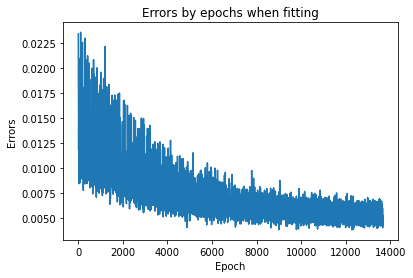

In [17]:
import matplotlib.pyplot as plt

plt.plot(sgd.loss)
plt.xlabel('Epoch')
plt.ylabel('Errors')
plt.title('Errors by epochs when fitting')
plt.show()

Faremos então os múltiplos gráficos para diferentes valores de _batch-size_ utilizando o conjunto de validation representando as perdas através das epochs, sendo possível visualizar as curvas de aprendizado:

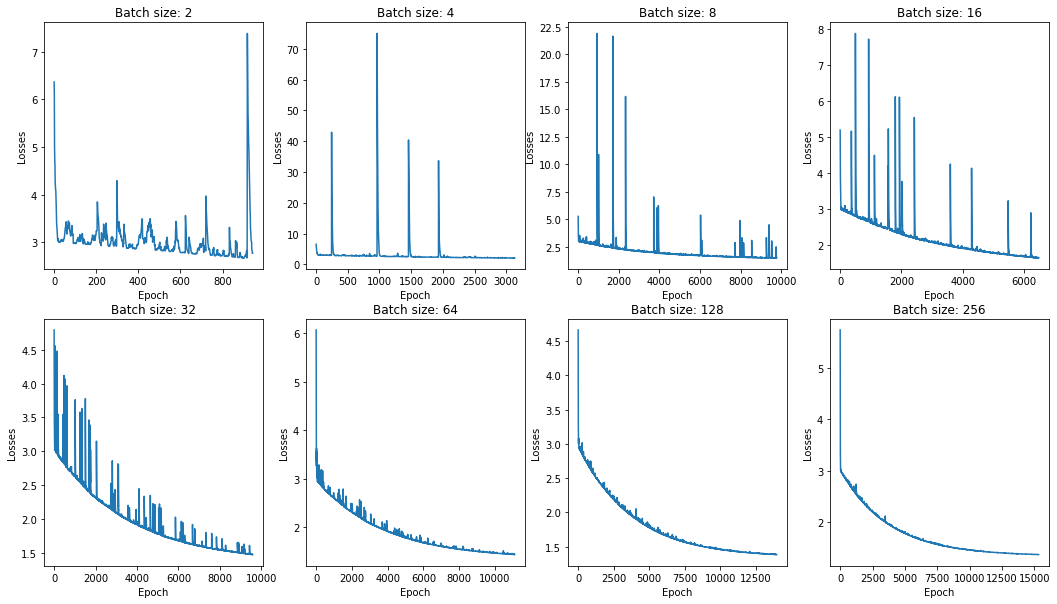

In [170]:
# make figure
figure = plt.figure(figsize=(18, 10))

for i in range(1, 9):
    sgd = SGD(batch_size=2**i)
    sgd.fit(features_train, labels_train)
    errors = []
    # add bias
    X = np.hstack((np.ones((features_validation.shape[0], 1)), features_validation))
    for theta in range(len(sgd.thetas)):
        error = np.mean((X.dot(sgd.thetas[theta]) - labels_validation.reshape(-1, 1)) ** 2)
        errors.append(error)
    ax = figure.add_subplot(2, 4, i)
    ax.plot(errors)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Losses')
    ax.set_title(f'Batch size: {2**i}')
    
plt.show()

Podemos observar, aqui, a partir de _batch-sizes_ maiores que 32, temos valores de perdas baixos, chegando ao final em valores próximos a 1.5. No entanto, em valores mais próximos a 256, temos curvas de aprendizado com losses baixas e mais suaves, que não tem crescimentos abruptos tão relevantes (por exemplo, no batch de tamanho 32, apesar de já estarmos em 1.5, o gráfico ainda varia muito, então um theta qualquer na epoch 10000 pode não ser tão bom). Note que conforme aumentamos o tamanho dos _batches_ tivemos losses menores porém também mais epochs, isto é, um tempo maior de treinamento (já que em nossa implementação o número de epochs representa as iterações).

Vamos avaliar o MSE no conjunto de teste:

In [26]:
sgd.predict(features_test)

print("MSE: ", np.mean((sgd.predict(features_test) - labels_test)**2))

MSE:  1.3320430243966261


Vamos, agora, fazer um regressor OLS:

In [33]:
class OLS():
    def __init__(self):
        self.theta = None

    def fit(self, X, y):
        # add bias 
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return X.dot(self.theta)

Testando no conjunto de validation e test:

In [34]:
ols = OLS()

ols.fit(features_train, labels_train)
ols.predict(features_validation)

print("MSE: ", np.mean((ols.predict(features_validation) - labels_validation)**2))

MSE:  0.535625380728718


In [35]:
ols = OLS()

ols.fit(features_train, labels_train)
ols.predict(features_test)

print("MSE: ", np.mean((ols.predict(features_test) - labels_test)**2))

MSE:  0.5420849540780263


**Exercício 2.** Agora, você deve implementar uma **Rede RBF** com função de base Gaussiana (veja as notas de aula).
Para os centróides, utilize o output de um modelo de clusterização por K médias, por meio da função que disponibilizamos, como a seguir:

In [36]:
def k_means_factory(n_clusters: int) -> KMeans:
    return KMeans(n_clusters=n_clusters, n_init="auto")
 
k_means_model = k_means_factory(n_clusters=2)
dumb_data = np.array(
    [[1, 2],
     [1, 4],
     [1, 0],
     [10, 2],
     [10, 4],
     [10, 0]], 
)
k_means_model.fit(dumb_data)
cluster_centers = k_means_model.cluster_centers_
print(cluster_centers) # Shape (n_clusters, n_features)

[[10.  2.]
 [ 1.  2.]]


Para determinar o melhor valor de $k$ para o algoritmo de clusterização, treine o modelo (usando a fórmula de OLS) com diferentes valores e escolha o que possuir o menor erro de validação. Faça um gráfico mostrando o valor do erro de validação para diferentes valores de $k$. Mostre também a performance do modelo escolhido no conjunto de teste. Compare com o modelo linear simples da questão anterior. Discuta os resultados.

Para definir o valor do hiper-parâmetro $\gamma$, use a seguinte heurística --- que pode ser achado no livro "Neural Networks", por Simon Haykin:

$$
\gamma = \frac{1}{d_\text{max}^2},
$$

onde $d_\text{max}$ é a maior distância entre um par de centróides. Note que o valor costuma mudar para $k$'s diferentes.


In [154]:
class RBF():
    def __init__(self, n_clusters=3, gamma=1):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.cluster_centers = None
        self.theta = None

    def ols(self, X, y):
        self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        return self.theta


    def fit(self, X, y):
        # add bias
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # cluster centers
        k_means_model = k_means_factory(n_clusters=self.n_clusters)
        k_means_model.fit(X)
        self.cluster_centers = k_means_model.cluster_centers_

        # calculate max distance
        max_dist = np.max(np.linalg.norm(self.cluster_centers - self.cluster_centers[:, None], axis=-1))
        # calculate gamma
        self.gamma = 1/max_dist**2
        # calculate rbf
        rbf = np.exp(-self.gamma * np.linalg.norm(X[:, None] - self.cluster_centers, axis=-1)**2)

        # train with OLS
        y = y.reshape(-1, 1)
        self.theta = self.ols(rbf, y)


    def predict(self, X):
        # add bias
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # calculate rbf
        rbf = np.exp(-self.gamma * np.linalg.norm(X[:, None] - self.cluster_centers, axis=-1)**2)
        return rbf.dot(self.theta)


Construímos, acima, nossa RBF. Vamos aplicá-la ao conjunto de validation para diferentes valores de k:

In [155]:
ks = []
for k in range(2, 20):
    rbf = RBF(n_clusters=k)
    rbf.fit(features_train, labels_train)
    ks.append(np.mean((rbf.predict(features_validation) - labels_validation)**2))

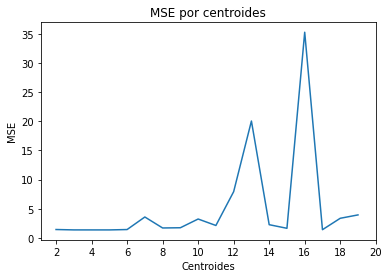

In [157]:
plt.plot(range(2, 20), ks)
plt.xlabel('Centroides')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.ylabel('MSE')
plt.title('MSE por centroides')
plt.show()

Observando o gráfico de resultados é possível concluir que, para valores de k mais baixos, temos MSEs mais satisfatórios. Quando esse valor começa a crescer, o MSE passa a variar muito, atingindo alguns bem mais altos. Quando levamos k a valores realmente mais altos, temos MSEs altos demais, mostrando que o excesso de centroides gera um overfitting nos dados pelo excesso de clusters.

In [158]:
print("MSE: ", min(ks), "Centroides: ", ks.index(min(ks))+2)

MSE:  1.3554246708531845 Centroides:  5


Por fim, calculamos qual o número de centroides com o qual nosso modelo melhor se adapta, sendo nesse caso com 5! Vamos fazer o mesmo para o conjunto de teste:

In [167]:
ks = []
for k in range(2, 20):
    rbf = RBF(n_clusters=k)
    rbf.fit(features_train, labels_train)
    ks.append(np.mean((rbf.predict(features_test) - labels_test)**2))

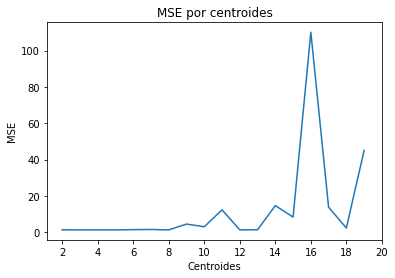

In [168]:
plt.plot(range(2, 20), ks)
plt.xlabel('Centroides')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.ylabel('MSE')
plt.title('MSE por centroides')
plt.show()

Para o conjunto de teste, obtivemos valores parecidos! O modelo funciona muito bem para poucos clusters mas, conforme aumentamos o valor de k, temos centros demais e os resultados são mais variados, sendo piores com mais frequência. O modelo linear simples feito anteriormente (OLS) apresenta valores de MSE um pouco mais baixos que os do RBF com 5 centroides, e é interessante observar que um pequeno aumento no número de clusters torna o resultado muito pior. Nesse caso, a transformação não traz ganho em relação à minimização da perda, então pode-se imaginar que os dados tenham, de fato, uma relação linear.

# Exercícios de "papel e caneta"

**Exercício 1.** Deixe que $X \in \mathbb{R}^{N\times D}$, $c>0$ e $I$ denote a matriz identidade de dimensão $N$.
 Mostre que $X^\intercal X + c I$ possui inversa.

**Resposta:**

Escolhemos um vetor arbitrário $y$ não nulo. Queremos mostrar que $$y^T (X^TX+ cI) y > 0$$ isto é, que $X^TX+ cI$ é definida positiva e portanto possui inversa. Note que podemos aplicar a distributiva: $$y^T X^T X y + y^T c I y$$

Vamos analisar cada parte. Sabemos que $y^T X^T X y$ é necessariamente semi-definida positiva, já que $X^T X$ é simétrico e $y$ é não nulo. Dessa forma, temos que $y^T X^T X y \geq 0$. 

Quanto a $ y^T c I y$, temos:

$$y^T c I y$$
$$y^T c y$$

Como $c$ é um escalar, podemos escrever:

$$c y^Ty$$

E $y^Ty$ representa um produto interno, e como $y$ não é nulo, sabemos que resultará em um escalar necessariamente maior que zero. Sendo assim, temos $c>0$ multiplicado por outro escalar positivo, então sabemos que certamente $y^T c I y>0$.

Assim, como  $y^T X^T X y \geq 0$ e $y^T c I y>0$, sabemos que $y^T (X^TX+ cI) y > 0$, então $X^TX+ cI$ é invertível.


**Exercício 2.** Deixe que $X \in \mathbb{R}^{N\times D}$ seja uma matriz contendo os exemplos de treinamento (um por linha) e que $y\in \mathbb{R}^N$ seja um vetor coluna os outputs observados para cada vetor de input em suas linhas. Na aula, derivamos a solução de mínimos quadrados ordinários (OLS). Use o mesmo raciocínio para resolver achar o vetor de pesos ${\theta}$ que minimiza:
 

 
$$ \|X \theta - y\|_2^2 + c \|\theta\|_2^2 $$

onde $c>0$ é uma constante.

**Resposta:**

Vamos reescrever $ \|X \theta - y\|_2^2 + c \|\theta\|_2^2 $:

$$(X \theta -y)^T(X \theta -y) + c \theta ^T \theta$$
$$\theta ^T X^T X \theta - 2 y^T X \theta + y^T y +c \theta^T \theta  $$

Agora, para minimizar $\theta$, faremos a derivada e igualaremos a zero, uma vez que a função é estritamente convexa, já que como provamos na questão anterior, uma expressão $(X \theta -y)^T(X \theta -y) + c \theta ^T \theta$ é definida positiva, sendo necessariamente estritamente convexa:

$$\nabla_{\theta} = 2 (X^T X \theta - X^T y) + \theta (2c) = 0$$ 
$$ 2 (X^T X \theta - X^T y+ \theta c) = 0$$
$$X^T X \theta - X^T y+ \theta c = 0$$
$$ (X^T X + c) \theta -  X^T y =0  $$
$$ (X^T X + I c)\theta  =  X^T y$$

Como vimos no exercício anterior, $X^T X + Ic $ possui inversa, então:

$$\theta = (X^T X + I c)^{-1} X^T y $$

**Exercício 3.** Em algumas situações, temos muito mais features que amostras ($D \gg N$). Esse tipo de cenário é comum, e.g., na análise de dados genômicos. Nesse caso, costumam existir infinitas combinações lineares das features que expressam o vetor de saídas $y$. Portanto, precisamos de algum critério para escolher um deles. Uma abordagem possível, é escolher o vetor de pesos $\theta$ que possua menor norma L2.
Com isso em mente, derive a solução que minimiza $\|\theta\|_2^2$ e respeita $X \theta = y$. Assuma que as linhas de $X$ são linearmente independentes

**Resposta:**

Queremos minimizar $||\theta^T \theta || $ sujeito a $X \theta $. Como temos uma função estritamente convexa com restrição, utilizaremos os Multiplicadores de Lagrange, garantindo que chegaremos ao mínimo. Portanto, temos:

$$L(\lambda, X)= \theta^T \theta + \lambda (X \theta - y)$$

Derivamos, portanto, em relação a $\lambda$ e $X$, chegando ao sistema:

$$ \begin{cases}
X \theta - y = 0 \\
2 \theta + X^T \lambda^T = 0
\end{cases}$$

Isolando $\theta$ na segunda equação, temos:

$$\theta = \dfrac{-X^T \lambda^T}{2}$$

E substituindo na primeira:

$$X \dfrac{-X^T \lambda^T}{2} - y = 0$$

Como sabemos que $X$ tem linhas linearmente independentes e $X \in R^{D \times N} $, podemos afirmar que $X X^T$ é invertível. Assim:

$$ \lambda^T = -2 (X X^T)^{-1} y $$

Fazendo a substituição de volta na segunda equação temos:

$$2 \theta + X^T  ( -2 (X X^T)^{-1} y ) = 0$$
$$2 \theta - 2 X^T(XX^T)^{-1} y = 0$$
$$\theta = X^T(XX^T)^{-1} y$$

Assim, encontramos a solução minimizadora da função respeitando as restrições.